In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from copy import deepcopy

sns.set()
sns.set_style(style="whitegrid")
sns.set_color_codes("colorblind")

We define this dictionary since the graph we use across this enire homwork has the same nodes and indices, so that we can use this dictionary to access the index of each node with its name.

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
%cd /content/drive/MyDrive/Colab Notebooks/Network Dynamics and Learning/H2

/content/drive/MyDrive/Colab Notebooks/Network Dynamics and Learning/H2


In [3]:
states = {
    "o": 0,
    "a": 1,
    "b": 2,
    "c": 3,
    "d": 4
}

# Problem 1.

We define the transition rate matrix $\Lambda$ for the first problem as given in the specifications.

In [5]:
Lambda = np.array([
    [0, 2/5, 1/5, 0, 0],
    [0, 0, 3/4, 1/4, 0],
    [1/2, 0, 0, 1/2, 0],
    [0, 0, 1/3, 0, 2/3],
    [0, 1/3, 0, 1/3, 0]
])

## a. What is, according to the simulations, the average time it takes a particle that starts in node a to leave the node and then return to it?

In [ ]:
# declaration of some useful arrays, matrices and variables as defined in the theory
w = np.sum(Lambda, axis=1)
w_star = np.max(w)

Q = (deepcopy(Lambda) - np.diag(Lambda)) / w_star
Q += np.diag(1 - np.sum(Q, axis=1))

D = np.diag(w)
P = np.linalg.inv(D) @ Lambda

In [ ]:
def simulateWalkTime(w_star, Q, o, d=None, n_simulations=1000, seed=None):
    """
    This functions simulates for n_simulations times a walk between a node o to
    a node d and returning an estimate of the return-time.
    In case the node o is different from the node d this function estimates the 
    hitting time.
    """

    return_times = []  # array to accumulate simulated return times

    if seed:  # for reproducibility reasons
        np.random.seed(seed)

    if not d:  # if the destination node is not defined this functions computes the return time to o
        d = o

    for j in range(n_simulations):
        # initial conditions
        pos = o
        has_left_o = False if o == d else True
        time = 0

        while True:
            # simulate the time at which the step happens
            t_next = -np.log(np.random.rand()) / w_star
            time += t_next

            # simulate the choice of the next node
            pos = np.random.choice(len(states), p=Q[pos,:])
            if not has_left_o and pos != o:
                has_left_o = True
            elif has_left_o and pos == d:
                break

        return_times.append(time)

    return np.mean(return_times)

In [ ]:
rt_sim = simulateWalkTime(w_star, Q, o=states['a'], n_simulations=100000, seed=20)
print(f"The estimated return time given by 100000 simulations is {rt_sim:.5}")

The estimated return time given by 100000 simulations is 6.7804


## b. How does the result in (a) compare to the theoretical return-time $E_a[T_a^+]$?

From Kac's theorem we can exploit the stationary distribution to define the theoretical value of the return time as:
$$E_a[T_a^+] = \frac{1}{\pi_a}.$$

In [15]:
v, w = np.linalg.eig(Q.T)
index = np.argmax(v.real)
pi = w[:,index].real
pi /= np.sum(pi)

In [ ]:
rt_theo = 1 / pi[states["a"]]
print(f"Theoretical return time: {rt_theo:.5}")

Theoretical return time: 6.75


In [ ]:
print(f"Simulations result differs by {100*(rt_sim - rt_theo)/rt_theo:.5}% from the theoretical result")

Simulations result differs by 0.4506% from the theoretical result


## c. What is, according to the simulations, the average time it takes to move from node o to node d?

We can exploit the function we defined above to compute the return time. This is the case since having two distinct nodes the return-time coincides with the hitting time.

In [ ]:
ht_sim = simulateWalkTime(w_star, Q, states['o'], states['d'], n_simulations=100000, seed=20)
print(f"The estimated hitting time given by 100000 simulations is {ht_sim:.5}")

The estimated hitting time given by 100000 simulations is 8.7968


## d. How does the result in (c) compare to the theoretical hitting-time $E_o[T_d]$?

In [ ]:
S = [states["d"]]  # set as stubborn the node we would like to reach
R = [i for i in states.values() if i not in S]  # the rest is regular
w = np.sum(Lambda, axis=1)

Q = P[np.ix_(R, R)]  # select the submatrix connected with the regular nodes
hts = np.linalg.inv(np.eye(len(states)-1) - Q) @ (np.ones(len(R)) / w[np.ix_(R)])

In [ ]:
ht_theo = hts[0]
print(f"The theoreticl hitting time of d starting from o is {ht_theo:.5}")

The theoreticl hitting time of d starting from o is 8.7857


In [ ]:
print(f"Simulations result differs by {100*(ht_sim - ht_theo)/ht_theo:.5}% from the theoretical result")

Simulations result differs by 0.12654% from the theoretical result


## e. Interpret the matrix $\Lambda$ as the weight matrix of a graph $\mathcal{G} = (V; E; \Lambda)$ , and simulate the French-DeGroot dynamics on G with an arbitrary initial condition $x(0)$. Does the dynamics converge to a consensus state for every initial condition $x(0)$? Motivate your answer.

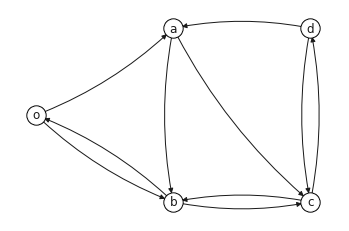

In [7]:
# define the graph
G = nx.from_numpy_matrix(Lambda, create_using=nx.DiGraph())
G = nx.relabel_nodes(G, {v: k for k, v in states.items()})
pos = {
    "o": [0, 0],
    "a": [1, 0.5],
    "b": [1, -0.5],
    "c": [2, -0.5],
    "d": [2, 0.5]
}

# plot
nx.draw_networkx_nodes(G, pos, linewidths=3, edgecolors="#000000")
nx.draw(G, pos, node_color="#ffffff", with_labels=True, connectionstyle="arc3, rad=0.1")
# plt.savefig("/content/drive/MyDrive/Colab Notebooks/Network Dynamics and Learning/H2/graph_1.pdf", bbox_inches="tight")

In [10]:
S = []  # no stubborns
R = [n for n in states.values() if n not in S]  # the rest (all nodes) is regular

u = []  # state of stubborns

A = Lambda
w = np.sum(A, axis=1)
D = np.diag(w)
P = np.linalg.inv(D) @ A

In [11]:
np.random.seed(20)
x0 = np.random.uniform(0, 1, len(R))
print("Arbitrary initial condition: ", x0)

Arbitrary initial condition:  [0.5881308  0.89771373 0.89153073 0.81583748 0.03588959]


In [16]:
v, w = np.linalg.eig(P.T)
index = np.argmax(v.real)
pi = w[:,index].real
pi /= np.sum(pi)

In [25]:
n_iterations = 25

x = np.zeros((len(states), n_iterations))
# set initial conditions 
x[S, 0] = u
x[R, 0] = x0

# run the French-de Groot dynamic
for t in range(1, n_iterations):
    x[:, t] = P @ x[:, t-1]
    
x_final = x[:, -1]

In [26]:
print(x_final)
print(f"The theoretical concensus value is {pi.T @ x0}")
print(f"The average distance from the theoretical concensus is {np.mean(abs(x_final - pi @ x0)):.5}")

[0.68448607 0.68464525 0.68412538 0.68502321 0.68402105]
The theoretical concensus value is 0.6844789086100547
The average distance from the theoretical concensus is 0.00030584


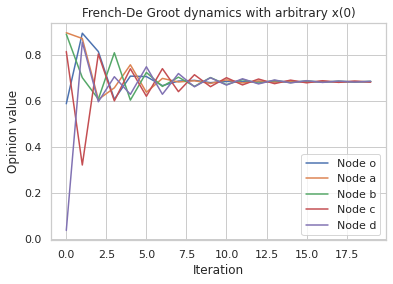

In [23]:
for n in G.nodes():
    plt.plot(x[states[n], :], label=f"Node {n}")

plt.title("French-De Groot dynamics with arbitrary x(0)")
plt.xlabel("Iteration")
plt.ylabel("Opinion value")
plt.legend()
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Network Dynamics and Learning/H2/fdg_od.pdf", bbox_inches="tight")

Since the graph is strongly connected and no stubborn node is present the system reachs a concensus state.

## f. Assume that the initial state of the dynamics for each node $i \in \mathcal{V}$ is given by $x_i(0) = \xi_i$, where $\xi_i$ are i.i.d random variables with variance $\sigma^2$. Compute the variance of the consensus value, and compare your results with numerical simulations.

To apply the wisdom of the crowds we require the graph to be strongly connected and aperiodic.

In [ ]:
nx.is_strongly_connected(G), nx.is_aperiodic(G)

(True, True)

In this case our graph is both strongly connected and aperiodic, so we can apply all the teoretical formulas we have.

$$Var(\sum \pi_k N_k) = \sigma^2 \sum{\pi_k^2}$$

In [27]:
v, w = np.linalg.eig(P.T)
index = np.argmax(v.real)
pi = w[:,index].real
pi /= np.sum(pi)

mu = 0  # mean for the random generation
std = 1  # the random generator requires standard deviation instead of variance

var_theo = std**2 * np.sum(pi**2)
print(f"The theoretically expected variance is {var_theo}")

The theoretically expected variance is 0.21361058601134214


In [ ]:
n_simulations = 1000

empirical_variances = []
np.random.seed(20)

# we simulate for n_simulations times the behavior after 100 steps on the system
# starting each time with a new random initial state.
for _ in range(n_simulations):
    x = np.random.normal(mu, std, len(states))
    for _ in range(100):
        x = P @ x
    var = (mu - x)**2  # empirical variance
    empirical_variances.append(var)

# averaging the empirical variances obtained we can obtain the simulated variance
# we can compare with the theoretical result
var_sim = np.mean(empirical_variances)
print(f"The variance from simulations is {var_sim}")

The variance from simulations is 0.212244239226231


In [ ]:
print(f"Simulations result differs by {100*(var_sim - var_theo)/var_theo:.5}% from the theoretical result")

Simulations result differs by -0.63964% from the theoretical result


## g. Remove the edges $(d; a)$ and $(d; c)$. Describe and motivate the asymptotic behaviour of the dynamics. If the dynamics converges to a consensus state, how is the consensus value related to the initial condition $x(0)$? Assume that the initial state of the dynamics for each node $i \in \mathcal{V}$ is given by $x_i(0) = \xi_i$, where $\xi_i$ are i.i.d random variables with variance $\sigma^2$. Compute the variance of the consensus value. Motivate your answer.

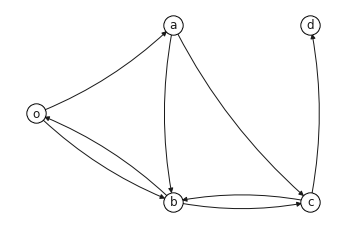

In [ ]:
# define the new graph
Gg = G.copy()
Gg.remove_edges_from([("d", "a"), ("d", "c")])

# plot
nx.draw_networkx_nodes(Gg, pos, linewidths=3, edgecolors="#000000")
nx.draw(Gg, pos, node_color="#ffffff", with_labels=True, connectionstyle="arc3, rad=0.1")

d would have null out degree and this would mean that computing the matrix P we would incurr in null determinant. To prevent this issue we add a self-loop on it.



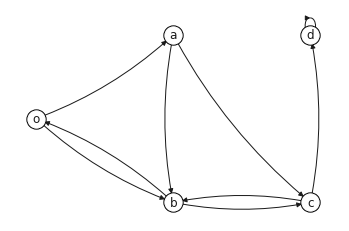

In [ ]:
Gg.add_edge("d", "d", weight=1)

# plot
nx.draw_networkx_nodes(Gg, pos, linewidths=3, edgecolors="#000000")
nx.draw(Gg, pos, node_color="#ffffff", with_labels=True, connectionstyle="arc3, rad=0.1")
plt.savefig("./graph_2.pdf", bbox_inches="tight")

In [ ]:
S = []  # no stubborns
R = [n for n in states.values() if n not in S]  # the rest is regular

u = []  # state of stubborns

A = nx.adjacency_matrix(Gg).toarray()
w = np.sum(A, axis=1)
D = np.diag(w)
P = np.linalg.inv(D) @ A

Q = P[np.ix_(R, R)]
E = P[np.ix_(R, S)]

v, w = np.linalg.eig(P.T)
index = np.argmax(v.real)
pi = w[:,index].real
pi /= np.sum(pi)

In [ ]:
np.random.seed(20)
x0 = np.random.uniform(0, 1, len(R))
print("Arbitrary initial condition: ", x0)

Arbitrary initial condition:  [0.5881308  0.89771373 0.89153073 0.81583748 0.03588959]


In [ ]:
n_iterations = 30

x = np.zeros((len(states), n_iterations))
x[S, 0] = u
x[R, 0] = x0

for t in range(1, n_iterations):
    x[R, t] = Q @ x[R, t-1] + E @ x[S, t-1]
    x[S, t] = x[S, t-1]
    
x_final = x[:, -1]

In [ ]:
x_final

array([0.03969137, 0.03905436, 0.03895085, 0.03712891, 0.03588959])

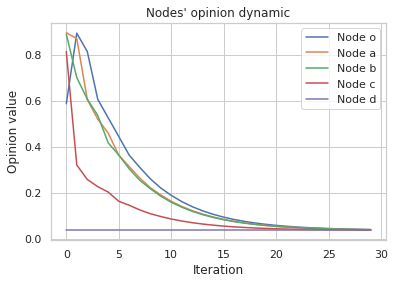

In [ ]:
for n in Gg.nodes():
    plt.plot(x[states[n], :], label=f"Node {n}")

plt.title("Nodes' opinion dynamic")
plt.xlabel("Iteration")
plt.ylabel("Opinion value")
plt.legend()
plt.savefig("./od_1g.pdf", bbox_inches="tight")

Node d behaves like a stubborn since it cannot see any other node to be influenced by

In [ ]:
v, w = np.linalg.eig(P.T)
index = np.argmax(v.real)
pi = w[:,index].real
pi /= np.sum(pi)

print(f"The theoretical concensus value is {pi @ x0}")
print(f"The mean distance from the theoretical concensus is {np.mean(x_final - pi @ x0):.3}")

The theoretical concensus value is 0.03588958561685329
The mean distance from the theoretical concensus is 0.00225


In [ ]:
mu = 0
std = 1

var_theo = std**2 * np.sum(pi**2)
print(f"The theoretically expected variance is {var_theo}")

The theoretically expected variance is 1.0


In [ ]:
n_sim = 1000

empirical_variances = []
np.random.seed(0)

# we simulate for n_sim times the French-DeGroot dynamic and average the variance
for _ in range(n_sim):
    x = np.random.normal(mu, std, len(states))
    for _ in range(100):
        x = P @ x
    var = (mu - x)**2  # computation of the variance at the end of the dynamic
    empirical_variances.append(var)

var_sim = np.mean(empirical_variances)
print(f"The variance from the simulations is {var_sim}")

The variance from the simulations is 0.9767933303452155


In [ ]:
print(f"The difference between the two variances is {var_theo - var_sim:.3}")

The difference between the two variances is 0.0232


## h.

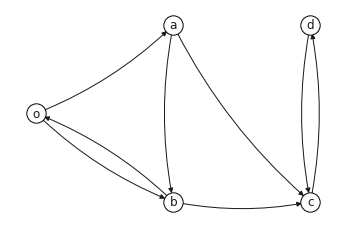

In [ ]:
Gh = G.copy()
Gh.remove_edges_from([("c", "b"), ("d", "a")])

# plot
nx.draw_networkx_nodes(Gh, pos, linewidths=3, edgecolors="#000000")
nx.draw(Gh, pos, node_color="#ffffff", with_labels=True, connectionstyle="arc3, rad=0.1")
plt.savefig("./graph_3.pdf", bbox_inches="tight")

The graph is not strongly connected anymore.

In [ ]:
S = []
R = [n for n in states.values() if n not in S]

u = []

A = nx.adjacency_matrix(Gh).toarray()
w = np.sum(A, axis=1)
D = np.diag(w)
P = np.linalg.inv(D) @ A

In [ ]:
np.random.seed(20)
x0 = np.random.uniform(0, 1, len(R))
print("Arbitrary initial condition: ", x0)

Arbitrary initial condition:  [0.5881308  0.89771373 0.89153073 0.81583748 0.03588959]


In [ ]:
n_iterations = 25

x = np.zeros((len(states), n_iterations))
x[S, 0] = u
x[R, 0] = x0

for t in range(1, n_iterations):
    x[:, t] = P @ x[:, t-1]
    
x_final = x[:, -1]

In [ ]:
x_final

array([0.45605607, 0.48600021, 0.21601122, 0.81583748, 0.03588959])

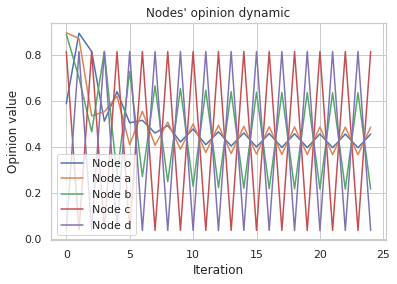

In [ ]:
for n in Gh.nodes():
    plt.plot(x[states[n], :], label=f"Node {n}")

plt.title("Nodes' opinion dynamic")
plt.xlabel("Iteration")
plt.ylabel("Opinion value")
plt.legend()
plt.savefig("od_1h.pdf", bbox_inches="tight")

# Problem 2

In [ ]:
w = np.sum(Lambda, axis=1)
w_star = np.max(w)

Q = (deepcopy(Lambda) - np.diag(Lambda)) / w_star
Q += np.diag(1 - np.sum(Q, axis=1))
D = np.diag(w)
P = np.linalg.inv(D) @ Lambda

## a. If 100 particles all start in node a, what is the average time for a particle to return to node a? How does this compare to the answer in Problem 1, why?

To do this we can repeat for a 100 times the experiment from Problem 1.a

In [ ]:
ret_times = []

time_units = 0
particles_in_system = 100
rate = particles_in_system
particles_pos = [states["a"]] * particles_in_system

while particles_in_system > 0:
    t_next = -np.log(np.random.rand()) / rate  # generate the next time
    time_units += t_next

    cur_particle = np.random.choice(len(particles_pos))  # randomly choose a particle

    cur_pos = particles_pos[cur_particle]  # get particle's position

    if cur_pos != None:  # the position is None iff the particle already returned in a
        next_pos = np.random.choice(len(states), p=Q[cur_pos, :])  # get next position

        if next_pos != states["a"]:
            particles_pos[cur_particle] = next_pos
        elif cur_pos != states["a"]:  # but goes to a
            particles_pos[cur_particle] = None
            particles_in_system -= 1
            ret_times.append(time_units)

print(f"Average return time to a for 100 particles: {np.mean(ret_times):.5}")

Average return time to a for 100 particles: 6.2626


In [ ]:
ret_times = []

time_units = 0
particles_in_system = 100000
rate = particles_in_system
particles_pos = [states["a"]] * particles_in_system

while particles_in_system > 0:
    t_next = -np.log(np.random.rand()) / rate  # generate the next time
    time_units += t_next

    cur_particle = np.random.choice(len(particles_pos))  # randomly choose a particle

    cur_pos = particles_pos[cur_particle]  # get particle's position

    if cur_pos != None:  # the position is None iff the particle already returned in a
        next_pos = np.random.choice(len(states), p=Q[cur_pos, :])  # get next position

        if next_pos != states["a"]:
            particles_pos[cur_particle] = next_pos
        elif cur_pos != states["a"]:  # but goes to a
            particles_pos[cur_particle] = None
            particles_in_system -= 1
            ret_times.append(time_units)

print(f"Average return time to a for 100000 particles: {np.mean(ret_times):.5}")

Average return time to a for 100 particles: 6.73


## b. If 100 particles start in node o, and the system is simulated for 60 time units, what is the average number of particles in the di
erent nodes at the end of the simulation? Illustrate the simulation above with a plot showing the number of particles in each node during the simulation time. Compare the simulation result in the 
rst point above with the stationary distribution of the continuous-time random walk followed by the single particles.

In [ ]:
time_units = 0
tot_particles = 100
max_time_units = 60
particles = []
particles.append([0]*len(states))
particles[0][0] = tot_particles
times = [0]

np.random.seed(20)
while time_units < max_time_units:
    # get actual system configuration
    cur_particles = deepcopy(particles[-1])
    # generate the next time stamp
    t_next = -np.log(np.random.rand())/(tot_particles*w_star)
    time_units += t_next
    if time_units <= max_time_units:
        # select the node from which the particle will move
        cur_node = np.random.choice(len(states), p=np.array(cur_particles)/tot_particles)
        # remove a particle from the node
        cur_particles[cur_node] -= 1

        # select the node to which the particle will mode
        next_node = np.random.choice(len(states), p=Q[cur_node, :])
        # add a particle to the new node
        cur_particles[next_node] += 1

        # update the states
        particles.append(cur_particles)
        times.append(time_units)

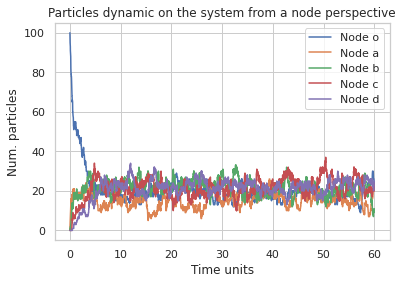

In [ ]:
particles = np.array(particles).T
for node in states:
    plt.plot(times, particles[states[node], :], label=f"Node {node}")

plt.legend()
plt.xlabel("Time units")
plt.ylabel("Num. particles")
plt.title("Particles dynamic on the system from a node perspective")
plt.savefig("./particles_dynamic_node_perspective_2b1.pdf", bbox_inches="tight")

In [ ]:
particles.mean(axis=1)

array([20.75875614, 15.26726678, 21.60229133, 21.25302782, 21.11865794])

In [ ]:
v, w = np.linalg.eig(Q.T)
index = np.argmax(v.real)
pi = w[:,index].real
pi /= np.sum(pi)

print(pi*tot_particles)

[18.51851852 14.81481481 22.22222222 22.22222222 22.22222222]


If we do it for a longer period (e.g., 600 time units)of time we get almost non contribute from the initial transition and so we have can approximate much better the stationary distribution.

In [ ]:
time_units = 0
tot_particles = 100
max_time_units = 10000
particles = []
particles.append([0]*len(states))
particles[0][0] = tot_particles
times = [0]

np.random.seed(20)
while time_units < max_time_units:
    # get actual system configuration
    cur_particles = deepcopy(particles[-1])
    # generate the next time stamp
    t_next = -np.log(np.random.rand())/(tot_particles*w_star)
    time_units += t_next
    if time_units <= max_time_units:
        # select the node from which the particle will move
        cur_node = np.random.choice(len(states), p=np.array(cur_particles)/tot_particles)
        # remove a particle from the node
        cur_particles[cur_node] -= 1

        # select the node to which the particle will mode
        next_node = np.random.choice(len(states), p=Q[cur_node, :])
        # add a particle to the new node
        cur_particles[next_node] += 1

        # update the states
        particles.append(cur_particles)
        times.append(time_units)

particles = np.array(particles).T

np.mean(particles, axis=1)

array([18.58365434, 14.84374468, 22.23583526, 22.21124165, 22.12552407])

As we can see the approximation of the stationary distribution is much more accurate over this amount of time units.

# Problem 3

## a. Proportional rate: Simulate the system for 60 time units and plot the evolution of the number of particles in each node over time. What is the largest input rate that the system can handle without blowing up?

In [ ]:
Lambda_open = np.array([[0, 3/4, 3/8, 0, 0],
                        [0, 0, 1/4, 1/4, 2/4],
                        [0, 0, 0, 1, 0],
                        [0, 0, 0, 0, 1],
                        [0, 0, 0, 0, 0]])

w = np.sum(Lambda_open - np.diag(Lambda_open), axis=1)
w[states["d"]] = 2
w_star = np.max(w)

D = np.diag(w)
P = np.linalg.inv(D) @ Lambda_open

Pbar = (deepcopy(Lambda_open) - np.diag(Lambda_open)) / w_star
Pbar += np.diag(1 - np.sum(Pbar, axis=1))

### A clock for each node

In [ ]:
def proportional_rate_sim(input_rate):
    time = 0
    max_time_units = 60

    rates = np.concatenate((w, np.array([input_rate])))  # in the last position we have the input rate

    # simulate the dynamics over the network
    particles = [[0] * len(states)]
    times = [0]

    np.random.seed(20)
    while True:
        cur_particles = deepcopy(particles[-1])

        # simulate a tick for each node
        ts_next = -np.log(np.random.rand(rates.shape[0])) / (np.concatenate((np.array(cur_particles), np.array([1]))) * rates)
        # select the tick of a node if and only if it already has some particles or it is the input node
        ts_next[np.concatenate((np.array(cur_particles) <= 0, np.array([False])))] = np.inf

        # the fastest node to tick is selected
        node = np.argmin(ts_next)

        t_next = ts_next[node]
        time += t_next

        if time <= max_time_units:
            if node < len(states):  # system's nodes
                if cur_particles[node] > 0:  # do not remove particles if no particle is in there
                    cur_particles[node] -= 1

                    if node != states["d"]:  # if the node from which the particle moves away is not d we move it
                        next_node = np.random.choice(len(states), p=P[node, :])
                        cur_particles[next_node] += 1
            else:  # dummy node
                cur_particles[states["o"]] += 1

            particles.append(cur_particles)
            times.append(time)
        else:
            break

    return times, particles

<ipython-input-19-cdad3fdc3f71>:16: RuntimeWarning: divide by zero encountered in true_divide
  ts_next = -np.log(np.random.rand(rates.shape[0])) / (np.concatenate((np.array(cur_particles), np.array([1]))) * rates)
<ipython-input-19-cdad3fdc3f71>:16: RuntimeWarning: divide by zero encountered in true_divide
  ts_next = -np.log(np.random.rand(rates.shape[0])) / (np.concatenate((np.array(cur_particles), np.array([1]))) * rates)
<ipython-input-19-cdad3fdc3f71>:16: RuntimeWarning: divide by zero encountered in true_divide
  ts_next = -np.log(np.random.rand(rates.shape[0])) / (np.concatenate((np.array(cur_particles), np.array([1]))) * rates)
<ipython-input-19-cdad3fdc3f71>:16: RuntimeWarning: divide by zero encountered in true_divide
  ts_next = -np.log(np.random.rand(rates.shape[0])) / (np.concatenate((np.array(cur_particles), np.array([1]))) * rates)
<ipython-input-19-cdad3fdc3f71>:16: RuntimeWarning: divide by zero encountered in true_divide
  ts_next = -np.log(np.random.rand(rates.shape

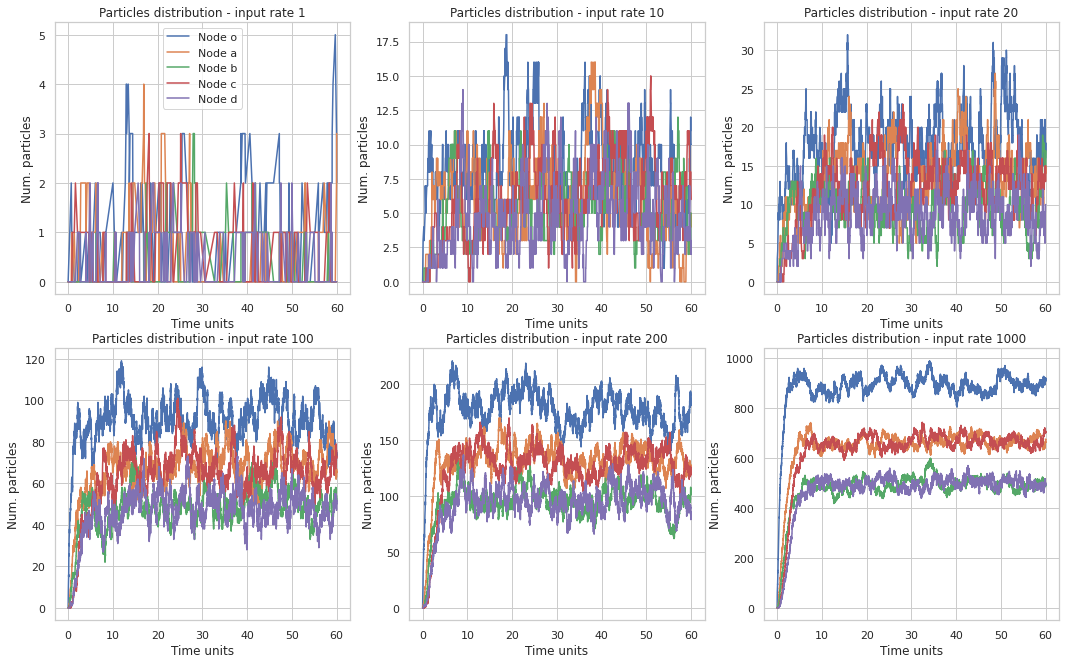

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(18, 11))
i = 0
for input_rate in [1, 10, 20, 100, 200, 1000]:
    times, particles = proportional_rate_sim(input_rate)

    particles = np.array(particles).T

    for node in states.keys():
        ax[int(np.floor(i/3))][i % 3].plot(times, particles[states[node], :], label=f"Node {node}")

    if i == 0:
        ax[int(np.floor(i/3))][i % 3].legend()
    ax[int(np.floor(i/3))][i % 3].set_xlabel("Time units")
    ax[int(np.floor(i/3))][i % 3].set_ylabel("Num. particles")
    ax[int(np.floor(i/3))][i % 3].set_title(f"Particles distribution - input rate {input_rate}")

    i += 1

plt.savefig("./particles_distribution_proportional_rate.pdf", bbox_inches="tight")

As we can clearly see in the chart the system does not blow up with any input rate having proportional transition rate.

### A gloabl clock for each node and a clock for the input

This was done just to check if we could apply the global clock concept to this new problem.

In [ ]:
def get_prev_o_tick(t, prev, o_ticks):
    for i in range(prev, len(o_ticks)):
        if o_ticks[i] > t:
            return i - 1
    return len(o_ticks) - 1

def proportional_rate_sim2(input_rate):
    # simultate times entering in the system
    time = 0
    max_time_units = 60
    o_ticks = [0]

    np.random.seed(2)
    while True:
        t_next = -np.log(np.random.rand()) / input_rate
        time += t_next
        if time < max_time_units:
            o_ticks.append(time)
        else:
            break
    # simulate the dynamics over the network
    time = o_ticks[1]
    particles = []
    particles.append([0] * len(states))
    particles.append([1] + [0] * (len(states) - 1))
    times = [0, time]
    prev_o_tick = 1
    node = states["o"]

    np.random.seed(0)
    while True:
        cur_particles = deepcopy(particles[-1])
        t_next = -np.log(np.random.rand()) / (np.sum(cur_particles) * w_star)
        time += t_next

        if time <= max_time_units:
            # check if any particle entered the system in the meanwhile
            o_tick = get_prev_o_tick(time, prev_o_tick, o_ticks)
            if o_tick > prev_o_tick:
                cur_particles[states["o"]] += o_tick - prev_o_tick  # there is a 1-to-1 matching between ticks and inseted particles
                prev_o_tick = o_tick

            # select the node from which a particle will move
            node = np.random.choice(len(states), p=np.array(cur_particles) / np.sum(cur_particles))

            if cur_particles[node] > 0:
                # remove a particle from the selected node
                cur_particles[node] -= 1

                if node != states["d"]:  # from d the particle can only exit the system
                    # select the node to which the particle will move
                    next_node = np.random.choice(len(states), p=Pbar[node, :])
                    cur_particles[next_node] += 1

            particles.append(cur_particles)
            times.append(time)
        else:
            break

    return times, particles

Text(0.5, 1.0, 'Proportional moving rate')

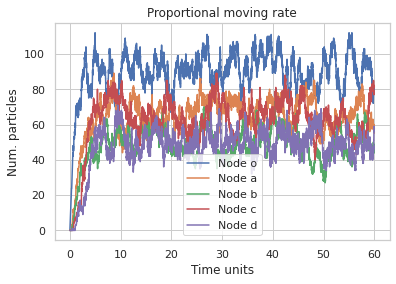

In [ ]:
times, particles = proportional_rate_sim2(100)

particles = np.array(particles).T

for node in states:
    plt.plot(times, particles[states[node], :], label=f"Node {node}")

plt.legend()
plt.xlabel("Time units")
plt.ylabel("Num. particles")
plt.title("Proportional moving rate")

As we can see the results are in line with the previous implementation.

## b.

In [ ]:
def fixed_rate_sim(input_rate):
    time = 0
    max_time_units = 60

    rates = np.concatenate((w, np.array([input_rate])))  # in the last position we have the input rate

    # simulate the dynamics over the network
    particles = [[0] * len(states)]
    times = [0]

    # np.random.seed(0)
    while True:
        cur_particles = deepcopy(particles[-1])

        ts_next = -np.log(np.random.rand(rates.shape[0])) / rates

        # select the tick of a node if and only if it already has some particles or it is the input node
        ts_next[np.concatenate((np.array(cur_particles) <= 0, np.array([False])))] = np.inf

        # the fastest node to tick is selected
        node = np.argmin(ts_next)

        t_next = ts_next[node]
        time += t_next

        if time <= max_time_units:
            if node < len(states):
                if cur_particles[node] > 0:
                    cur_particles[node] -= 1

                    if node != states["d"]:
                        next_node = np.random.choice(len(states), p=P[node, :])
                        cur_particles[next_node] += 1
            else:
                cur_particles[states["o"]] += 1

            particles.append(cur_particles)
            times.append(time)
        else:
            break

    return times, particles

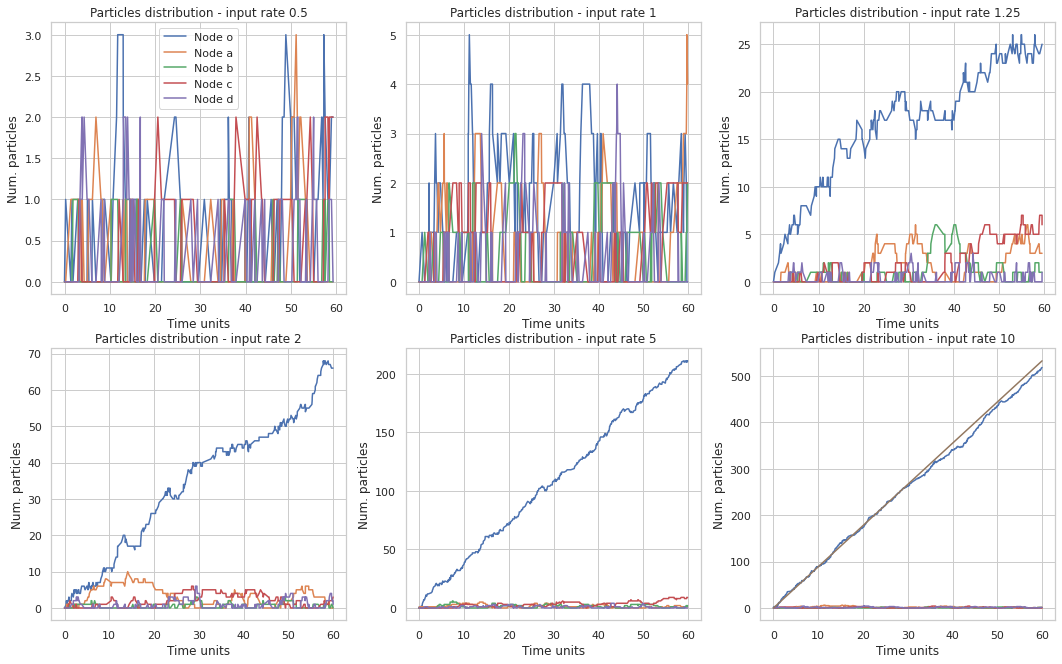

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(18, 11))
i = 0
for input_rate in [0.5, 1, 1.25, 2, 5, 10]:
    times, particles = fixed_rate_sim(input_rate)

    particles = np.array(particles).T

    for node in states.keys():
        ax[int(np.floor(i/3))][i % 3].plot(times, particles[states[node], :], label=f"Node {node}")

    if i == 0:
        ax[int(np.floor(i/3))][i % 3].legend()
    ax[int(np.floor(i/3))][i % 3].set_xlabel("Time units")
    ax[int(np.floor(i/3))][i % 3].set_ylabel("Num. particles")
    ax[int(np.floor(i/3))][i % 3].set_title(f"Particles distribution - input rate {input_rate}")
    if i == 5:
        ax[int(np.floor(i/3))][i % 3].plot(times, [t*(input_rate - w[states["o"]]) for t in times])

    i += 1

plt.savefig("./particles_distribution_fixed_rate.pdf", bbox_inches="tight")